# Statystyczna Analiza Danych Wina

Kompleksowa analiza zbioru danych `winequality-red.csv` obejmująca:

1. Przetwarzanie wstępne danych
2. Statystyki opisowe
3. Analiza korelacji
4. **Prosta regresja liniowa z wzorami**
5. Przygotowanie dla modeli ML (XGBoost/Random Forest)
6. Wizualizacja danych


## 1. Import bibliotek i wczytanie danych


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
import os
warnings.filterwarnings('ignore')

output_dir = 'wine_output'
os.makedirs(output_dir, exist_ok=True)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

df = pd.read_csv('datasets/winequality-red.csv')
print("Dane załadowane pomyślnie!")
print(f"Rozmiar zbioru danych: {df.shape}")
print("\nPierwsze 5 wierszy:")
df.head()

Dane załadowane pomyślnie!
Rozmiar zbioru danych: (1599, 12)

Pierwsze 5 wierszy:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## 2. Przetwarzanie wstępne - czyszczenie i obsługa brakujących danych


In [15]:
def clean_and_handle_missing_data(df):
    print("=== ANALIZA JAKOŚCI DANYCH ===\n")

    print("1. Informacje ogólne:")
    print(f"   - Wiersze: {df.shape[0]}")
    print(f"   - Kolumny: {df.shape[1]}")
    print(f"   - Typy danych:\n{df.dtypes}")

    print("\n2. Analiza brakujących wartości:")
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({
        'Kolumna': missing_values.index,
        'Brakujące wartości': missing_values.values,
        'Procent': missing_percentage.values
    })
    print(missing_df[missing_df['Brakujące wartości'] > 0])

    if missing_values.sum() == 0:
        print("   Nie znaleziono brakujących wartości!")

    print("\n3. Analiza duplikatów:")
    duplicates = df.duplicated().sum()
    print(f"   Liczba duplikatów: {duplicates}")

    print("\n4. Analiza zakresów wartości i wartości odstających:")
    df_clean = df.copy()

    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]

        print(f"   {column}:")
        print(f"      Zakres: [{df[column].min():.3f}, {df[column].max():.3f}]")
        print(f"      Wartości odstające: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

        if column == 'pH' and (df[column].min() < 2.5 or df[column].max() > 4.5):
            print(f"      UWAGA: Podejrzane wartości pH poza typowym zakresem win!")
        elif column == 'alcohol' and (df[column].min() < 8 or df[column].max() > 16):
            print(f"      UWAGA: Podejrzane wartości alkoholu poza typowym zakresem!")
        elif df[column].min() < 0:
            print(f"      UWAGA: Wykryto wartości ujemne!")

    if duplicates > 0:
        df_clean = df_clean.drop_duplicates()
        print(f"\n5. Usunięto {duplicates} duplikatów")

    def fill_missing_values(df, method='mean'):
        df_filled = df.copy()

        for column in df.columns:
            if df[column].isnull().sum() > 0:
                if method == 'mean':
                    df_filled[column].fillna(df[column].mean(), inplace=True)
                elif method == 'median':
                    df_filled[column].fillna(df[column].median(), inplace=True)
                elif method == 'random':
                    min_val, max_val = df[column].min(), df[column].max()
                    random_values = np.random.uniform(min_val, max_val, df[column].isnull().sum())
                    df_filled[column].fillna(pd.Series(random_values, index=df[df[column].isnull()].index), inplace=True)

        return df_filled

    if missing_values.sum() > 0:
        df_clean = fill_missing_values(df_clean, method='mean')
        print("6. Wypełniono brakujące wartości średnimi")

    print(f"\n=== DANE PO CZYSZCZENIU ===")
    print(f"Rozmiar: {df_clean.shape}")
    print("Czyszczenie danych zakończone pomyślnie!")

    return df_clean

df_clean = clean_and_handle_missing_data(df)

=== ANALIZA JAKOŚCI DANYCH ===

1. Informacje ogólne:
   - Wiersze: 1599
   - Kolumny: 12
   - Typy danych:
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

2. Analiza brakujących wartości:
Empty DataFrame
Columns: [Kolumna, Brakujące wartości, Procent]
Index: []
   Nie znaleziono brakujących wartości!

3. Analiza duplikatów:
   Liczba duplikatów: 240

4. Analiza zakresów wartości i wartości odstających:
   fixed acidity:
      Zakres: [4.600, 15.900]
      Wartości odstające: 49 (3.06%)
   volatile acidity:
      Zakres: [0.120, 1.580]
      Wartości odstające: 19 (1.19%)
   citric acid:
      Zakres: [0.000, 1.000]
      Wartości odstające:

## 3. Statystyki opisowe


In [16]:
def calculate_descriptive_statistics(df):
    print("=== STATYSTYKI OPISOWE ===\n")

    numeric_columns = df.select_dtypes(include=[np.number]).columns

    stats_dict = {}

    for column in numeric_columns:
        data = df[column]

        stats_dict[column] = {
            'Min': data.min(),
            'Max': data.max(),
            'Zakres': data.max() - data.min(),
            'Średnia': data.mean(),
            'Odch. std': data.std(),
            'Mediana': data.median(),
            'Q1 (25%)': data.quantile(0.25),
            'Q3 (75%)': data.quantile(0.75),
            'IQR': data.quantile(0.75) - data.quantile(0.25),
            'Kwantyl 0.1': data.quantile(0.1),
            'Kwantyl 0.9': data.quantile(0.9),
            'Skośność': data.skew(),
            'Kurtoza': data.kurtosis()
        }

    stats_df = pd.DataFrame(stats_dict).T

    print("Podstawowe statystyki opisowe:")
    print("="*80)

    main_stats = stats_df[['Min', 'Max', 'Zakres', 'Średnia', 'Odch. std', 'Mediana']]
    print(main_stats.round(3))

    print("\n" + "="*80)
    print("Kwartyle i kwantyle:")
    print("="*80)

    quartile_stats = stats_df[['Q1 (25%)', 'Mediana', 'Q3 (75%)', 'IQR', 'Kwantyl 0.1', 'Kwantyl 0.9']]
    print(quartile_stats.round(3))

    print("\n" + "="*80)
    print("Miary kształtu rozkładu:")
    print("="*80)

    shape_stats = stats_df[['Skośność', 'Kurtoza']]
    print(shape_stats.round(3))
    
    stats_df.round(3).to_csv(f'{output_dir}/descriptive_statistics.csv')
    print(f"\n✓ Statystyki zapisane do pliku: {output_dir}/descriptive_statistics.csv")

    print("\nInterpretacja kształtu:")
    for column in numeric_columns:
        skewness = stats_df.loc[column, 'Skośność']
        kurtosis = stats_df.loc[column, 'Kurtoza']

        if abs(skewness) < 0.5:
            skew_desc = "symetryczny"
        elif skewness > 0.5:
            skew_desc = "prawostronnie skośny (ogon po prawej)"
        else:
            skew_desc = "lewostronnie skośny (ogon po lewej)"

        if abs(kurtosis) < 0.5:
            kurt_desc = "mezokurtyczny (normalny)"
        elif kurtosis > 0.5:
            kurt_desc = "leptokurtyczny (ostry szczyt)"
        else:
            kurt_desc = "platykurtyczny (płaski szczyt)"

        print(f"  {column}: {skew_desc}, {kurt_desc}")

    return stats_df

descriptive_stats = calculate_descriptive_statistics(df_clean)

=== STATYSTYKI OPISOWE ===

Podstawowe statystyki opisowe:
                        Min      Max   Zakres  Średnia  Odch. std  Mediana
fixed acidity         4.600   15.900   11.300    8.311      1.737    7.900
volatile acidity      0.120    1.580    1.460    0.529      0.183    0.520
citric acid           0.000    1.000    1.000    0.272      0.196    0.260
residual sugar        0.900   15.500   14.600    2.523      1.352    2.200
chlorides             0.012    0.611    0.599    0.088      0.049    0.079
free sulfur dioxide   1.000   72.000   71.000   15.893     10.447   14.000
total sulfur dioxide  6.000  289.000  283.000   46.826     33.409   38.000
density               0.990    1.004    0.014    0.997      0.002    0.997
pH                    2.740    4.010    1.270    3.310      0.155    3.310
sulphates             0.330    2.000    1.670    0.659      0.171    0.620
alcohol               8.400   14.900    6.500   10.432      1.082   10.200
quality               3.000    8.000    5

## 4. Analiza korelacji liniowej Pearsona


In [17]:
def analyze_correlations(df):
    print("=== ANALIZA KORELACJI LINIOWEJ PEARSONA ===\n")

    numeric_columns = df.select_dtypes(include=[np.number]).columns

    correlation_matrix = df[numeric_columns].corr(method='pearson')

    print("1. Macierz korelacji Pearsona:")
    print("="*50)
    print(correlation_matrix.round(3))

    print("\n2. Silne korelacje (|r| > 0.5):")
    print("="*50)

    strong_correlations = []
    for i, col1 in enumerate(numeric_columns):
        for j, col2 in enumerate(numeric_columns):
            if i < j:
                corr_coef = correlation_matrix.loc[col1, col2]
                if abs(corr_coef) > 0.5:
                    _, p_value = pearsonr(df[col1], df[col2])
                    strong_correlations.append({
                        'Zmienna 1': col1,
                        'Zmienna 2': col2,
                        'Korelacja': corr_coef,
                        'p-wartość': p_value,
                        'Istotna (p<0.05)': 'Tak' if p_value < 0.05 else 'Nie'
                    })

    if strong_correlations:
        strong_corr_df = pd.DataFrame(strong_correlations)
        strong_corr_df = strong_corr_df.sort_values('Korelacja', key=abs, ascending=False)
        print(strong_corr_df)
    else:
        print("Brak korelacji z |r| > 0.5")

    print("\n3. Korelacje z jakością wina:")
    print("="*40)

    quality_correlations = []
    for column in numeric_columns:
        if column != 'quality':
            corr_coef, p_value = pearsonr(df[column], df['quality'])
            quality_correlations.append({
                'Zmienna': column,
                'Korelacja z jakością': corr_coef,
                'p-wartość': p_value,
                'Istotna (p<0.05)': 'Tak' if p_value < 0.05 else 'Nie'
            })

    quality_corr_df = pd.DataFrame(quality_correlations)
    quality_corr_df = quality_corr_df.sort_values('Korelacja z jakością', key=abs, ascending=False)
    print(quality_corr_df.round(4))

    print("\n4. Interpretacja siły korelacji:")
    print("="*40)
    print("0.0 - 0.2: bardzo słaba")
    print("0.2 - 0.4: słaba")
    print("0.4 - 0.6: umiarkowana")
    print("0.6 - 0.8: silna")
    print("0.8 - 1.0: bardzo silna")

    return correlation_matrix, strong_corr_df if strong_correlations else None, quality_corr_df

correlation_matrix, strong_correlations_df, quality_correlations_df = analyze_correlations(df_clean)

=== ANALIZA KORELACJI LINIOWEJ PEARSONA ===

1. Macierz korelacji Pearsona:
                      fixed acidity  volatile acidity  citric acid  \
fixed acidity                 1.000            -0.255        0.667   
volatile acidity             -0.255             1.000       -0.551   
citric acid                   0.667            -0.551        1.000   
residual sugar                0.111            -0.002        0.144   
chlorides                     0.086             0.055        0.210   
free sulfur dioxide          -0.141            -0.021       -0.048   
total sulfur dioxide         -0.104             0.072        0.047   
density                       0.670             0.024        0.358   
pH                           -0.687             0.247       -0.550   
sulphates                     0.190            -0.257        0.326   
alcohol                      -0.062            -0.198        0.105   
quality                       0.119            -0.395        0.228   

             

## 5. Prosta regresja liniowa


In [18]:
def perform_linear_regression_analysis(df):
    print("=== PROSTA REGRESJA LINIOWA ===\n")

    numeric_columns = df.select_dtypes(include=[np.number]).columns

    print("1. Regresja liniowa: predykcja jakości wina (sklearn)")
    print("="*50)

    correlations_with_quality = []
    for col in numeric_columns:
        if col != 'quality':
            corr = df[col].corr(df['quality'])
            correlations_with_quality.append((col, abs(corr), corr))

    correlations_with_quality.sort(key=lambda x: x[1], reverse=True)

    top_predictors = correlations_with_quality[:3]

    for i, (predictor, abs_corr, corr) in enumerate(top_predictors, 1):
        print(f"\n{i}. {predictor} → quality (r = {corr:.3f}):")
        print("-" * 40)

        X = df[[predictor]]
        y = df['quality']

        model = LinearRegression()
        model.fit(X, y)

        y_pred = model.predict(X)

        slope = model.coef_[0]
        intercept = model.intercept_
        r_squared = r2_score(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)

        print(f"   Wzór regresji liniowej:")
        print(f"   quality = {intercept:.4f} + {slope:.4f} × {predictor}")
        print(f"   ")
        print(f"   Parametry (sklearn):")
        print(f"   • Współczynnik kierunkowy (slope): a = {slope:.4f}")
        print(f"   • Wyraz wolny (intercept): b = {intercept:.4f}")
        print(f"   • Współczynnik korelacji: r = {corr:.4f}")
        print(f"   • Współczynnik determinacji: R² = {r_squared:.4f} ({r_squared*100:.1f}% wyjaśnionej wariancji)")
        print(f"   • Błąd średniokwadratowy (MSE): {mse:.4f}")
        print(f"   • Pierwiastek z MSE (RMSE): {rmse:.4f}")

        n = len(X)
        x_mean = X[predictor].mean()
        residuals = y - y_pred
        s_residual = np.sqrt(np.sum(residuals**2) / (n - 2))
        s_slope = s_residual / np.sqrt(np.sum((X[predictor] - x_mean)**2))
        t_stat = slope / s_slope

        print(f"   • Błąd standardowy współczynnika: {s_slope:.4f}")
        print(f"   • Statystyka t: {t_stat:.4f}")

        if corr > 0:
            print(f"   ✓ Zależność dodatnia: wzrost {predictor} o 1 jednostkę → wzrost quality o {slope:.4f}")
        else:
            print(f"   ✓ Zależność ujemna: wzrost {predictor} o 1 jednostkę → spadek quality o {abs(slope):.4f}")

        print(f"   ✓ Model score: {model.score(X, y):.4f}")

    print(f"\n" + "="*50)
    print("2. Regresja wielokrotna (multiple regression) - top 3 predyktory:")
    print("="*50)

    top_3_vars = [x[0] for x in top_predictors]
    X_multi = df[top_3_vars]
    y = df['quality']

    model_multi = LinearRegression()
    model_multi.fit(X_multi, y)

    y_pred_multi = model_multi.predict(X_multi)
    r_squared_multi = r2_score(y, y_pred_multi)
    mse_multi = mean_squared_error(y, y_pred_multi)
    rmse_multi = np.sqrt(mse_multi)

    print(f"Regresja wielokrotna dla top 3 predyktorów:")
    formula = f"quality = {model_multi.intercept_:.4f}"
    for var, coef in zip(top_3_vars, model_multi.coef_):
        formula += f" + {coef:.4f}×{var}"
    print(formula)

    print(f"R² = {r_squared_multi:.4f} ({r_squared_multi*100:.2f}% wyjaśnionej wariancji)")
    print(f"MSE = {mse_multi:.4f}, RMSE = {rmse_multi:.4f}")
    print(f"Model score = {model_multi.score(X_multi, y):.4f}")

    linear_r_squared = top_predictors[0][2] ** 2
    improvement = (r_squared_multi - linear_r_squared) * 100
    print(f"Poprawa względem prostej regresji liniowej: {improvement:.2f} punktów procentowych")

    print(f"\n3. Regresja wielomianowa (stopień 2) dla najlepszego predyktora:")
    print("="*50)

    from sklearn.preprocessing import PolynomialFeatures

    best_predictor = top_predictors[0][0]
    X_best = df[[best_predictor]]
    y = df['quality']

    poly_features = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly_features.fit_transform(X_best)

    model_poly = LinearRegression()
    model_poly.fit(X_poly, y)

    y_pred_poly = model_poly.predict(X_poly)
    r_squared_poly = r2_score(y, y_pred_poly)

    print(f"Regresja wielomianowa dla {best_predictor} (sklearn):")
    print(f"quality = {model_poly.intercept_:.4f} + {model_poly.coef_[0]:.4f}×{best_predictor} + {model_poly.coef_[1]:.4f}×{best_predictor}²")
    print(f"R² = {r_squared_poly:.4f} ({r_squared_poly*100:.2f}% wyjaśnionej wariancji)")
    print(f"Model score = {model_poly.score(X_poly, y):.4f}")

    improvement_poly = (r_squared_poly - linear_r_squared) * 100
    print(f"Poprawa względem prostej regresji liniowej: {improvement_poly:.2f} punktów procentowych")

    print(f"\n4. Regresja liniowa między wybranymi parami zmiennych:")
    print("="*50)

    predictor_vars = [x[0] for x in correlations_with_quality[:4]]

    print("Wzory regresji między zmiennymi (sklearn):")
    for i, var1 in enumerate(predictor_vars):
        for j, var2 in enumerate(predictor_vars):
            if i < j:
                X_pair = df[[var1]]
                y_pair = df[var2]

                model_pair = LinearRegression()
                model_pair.fit(X_pair, y_pair)

                slope = model_pair.coef_[0]
                intercept = model_pair.intercept_
                r_score = model_pair.score(X_pair, y_pair)

                correlation = df[var1].corr(df[var2])

                print(f"   {var2} = {intercept:.3f} + {slope:.3f} × {var1}")
                print(f"   (r = {correlation:.3f}, R² = {r_score:.3f}, sklearn score = {r_score:.3f})")

    print(f"\n5. Przygotowanie danych dla zaawansowanych modeli ML:")
    print("="*50)
    print("   ✓ Regresja liniowa wykonana (sklearn) - podstawa do porównania")
    print("   ✓ Dane przygotowane do modeli XGBoost/Random Forest")
    print("   ✓ Najlepszy predyktor liniowy:", best_predictor)
    print("   ✓ Modele sklearn gotowe do rozbudowy")

    return correlations_with_quality, model_multi, best_predictor

feature_ranking, multi_model, best_predictor = perform_linear_regression_analysis(df_clean)

=== PROSTA REGRESJA LINIOWA ===

1. Regresja liniowa: predykcja jakości wina (sklearn)

1. alcohol → quality (r = 0.480):
----------------------------------------
   Wzór regresji liniowej:
   quality = 1.8092 + 0.3656 × alcohol
   
   Parametry (sklearn):
   • Współczynnik kierunkowy (slope): a = 0.3656
   • Wyraz wolny (intercept): b = 1.8092
   • Współczynnik korelacji: r = 0.4803
   • Współczynnik determinacji: R² = 0.2307 (23.1% wyjaśnionej wariancji)
   • Błąd średniokwadratowy (MSE): 0.5214
   • Pierwiastek z MSE (RMSE): 0.7221
   • Błąd standardowy współczynnika: 0.0181
   • Statystyka t: 20.1744
   ✓ Zależność dodatnia: wzrost alcohol o 1 jednostkę → wzrost quality o 0.3656
   ✓ Model score: 0.2307

2. volatile acidity → quality (r = -0.395):
----------------------------------------
   Wzór regresji liniowej:
   quality = 6.5648 + -1.7783 × volatile acidity
   
   Parametry (sklearn):
   • Współczynnik kierunkowy (slope): a = -1.7783
   • Wyraz wolny (intercept): b = 6.5648
  

## 6. Przygotowanie dla zaawansowanych modeli ML


In [19]:
def prepare_for_ml_models(df):
    print("=== PRZYGOTOWANIE DANYCH DLA ZAAWANSOWANYCH MODELI ML ===\n")

    numeric_columns = df.select_dtypes(include=[np.number]).columns

    print("1. Ranking cech dla modeli ML:")
    print("="*50)

    correlations_with_quality = []
    for col in numeric_columns:
        if col != 'quality':
            corr = df[col].corr(df['quality'])
            correlations_with_quality.append((col, abs(corr), corr))

    correlations_with_quality.sort(key=lambda x: x[1], reverse=True)

    print("Ranking zmiennych według siły korelacji z jakością:")
    for i, (predictor, abs_corr, corr) in enumerate(correlations_with_quality, 1):
        direction = "dodatnia" if corr > 0 else "ujemna"
        strength = "bardzo silna" if abs_corr > 0.7 else "silna" if abs_corr > 0.5 else "umiarkowana" if abs_corr > 0.3 else "słaba"
        print(f"   {i:2d}. {predictor:20s}: r = {corr:6.3f} ({direction:8s}, {strength})")

    print(f"\n2. Charakterystyka zbioru danych:")
    print("="*50)
    print(f"   • Liczba próbek: {len(df)}")
    print(f"   • Liczba cech: {len(numeric_columns)-1}")
    print(f"   • Zmienna docelowa: quality (zakres: {df['quality'].min()}-{df['quality'].max()})")

    print(f"\n   • Rozkład klas jakości:")
    quality_counts = df['quality'].value_counts().sort_index()
    for quality, count in quality_counts.items():
        percentage = (count / len(df)) * 100
        print(f"     Jakość {quality}: {count:4d} próbek ({percentage:5.1f}%)")

    print(f"\n3. Analiza multikolinearności:")
    print("="*50)

    predictor_columns = [col for col in numeric_columns if col != 'quality']
    high_correlations = []

    for i, col1 in enumerate(predictor_columns):
        for j, col2 in enumerate(predictor_columns):
            if i < j:
                corr = df[col1].corr(df[col2])
                if abs(corr) > 0.7:
                    high_correlations.append((col1, col2, corr))

    if high_correlations:
        print("   Silnie skorelowane pary zmiennych (|r| > 0.7):")
        for col1, col2, corr in sorted(high_correlations, key=lambda x: abs(x[2]), reverse=True):
            print(f"     {col1} ↔ {col2}: r = {corr:.3f}")
        print("   UWAGA: Rozważ usunięcie jednej ze zmiennych z każdej pary")
    else:
        print("   Brak silnych korelacji między predyktorami (|r| > 0.7)")

    print(f"\n4. Rekomendacje dla modeli ML:")
    print("="*50)
    print("   ✓ Dane są gotowe do modelowania ML")
    print("   ✓ Brak brakujących wartości")

    top_3_predictors = [x[0] for x in correlations_with_quality[:3]]
    print(f"   ✓ Top 3 predyktory: {', '.join(top_3_predictors)}")

    print("   ✓ Random Forest: może obsłużyć wszystkie cechy")
    print("   ✓ XGBoost: może obsłużyć wszystkie cechy")

    if len(high_correlations) > 0:
        print("   ⚠ Uwaga: wykryto multikolinearność - może wpłynąć na interpretację")

    print(f"\n   Gotowy zbiór danych dla treningu modeli:")
    print(f"   • X (cechy): {len(predictor_columns)} zmiennych")
    print(f"   • y (cel): jakość wina")
    print(f"   • Rekomendowany podział: 80% trening, 20% test")

    return correlations_with_quality, top_3_predictors

ml_features, top_features = prepare_for_ml_models(df_clean)

=== PRZYGOTOWANIE DANYCH DLA ZAAWANSOWANYCH MODELI ML ===

1. Ranking cech dla modeli ML:
Ranking zmiennych według siły korelacji z jakością:
    1. alcohol             : r =  0.480 (dodatnia, umiarkowana)
    2. volatile acidity    : r = -0.395 (ujemna  , umiarkowana)
    3. sulphates           : r =  0.249 (dodatnia, słaba)
    4. citric acid         : r =  0.228 (dodatnia, słaba)
    5. density             : r = -0.184 (ujemna  , słaba)
    6. total sulfur dioxide: r = -0.178 (ujemna  , słaba)
    7. chlorides           : r = -0.131 (ujemna  , słaba)
    8. fixed acidity       : r =  0.119 (dodatnia, słaba)
    9. pH                  : r = -0.055 (ujemna  , słaba)
   10. free sulfur dioxide : r = -0.050 (ujemna  , słaba)
   11. residual sugar      : r =  0.014 (dodatnia, słaba)

2. Charakterystyka zbioru danych:
   • Liczba próbek: 1359
   • Liczba cech: 11
   • Zmienna docelowa: quality (zakres: 3-8)

   • Rozkład klas jakości:
     Jakość 3:   10 próbek (  0.7%)
     Jakość 4:   5

## 7. Wizualizacja danych


### 7.1 Wykresy kołowe i słupkowe - rozkład jakości wina


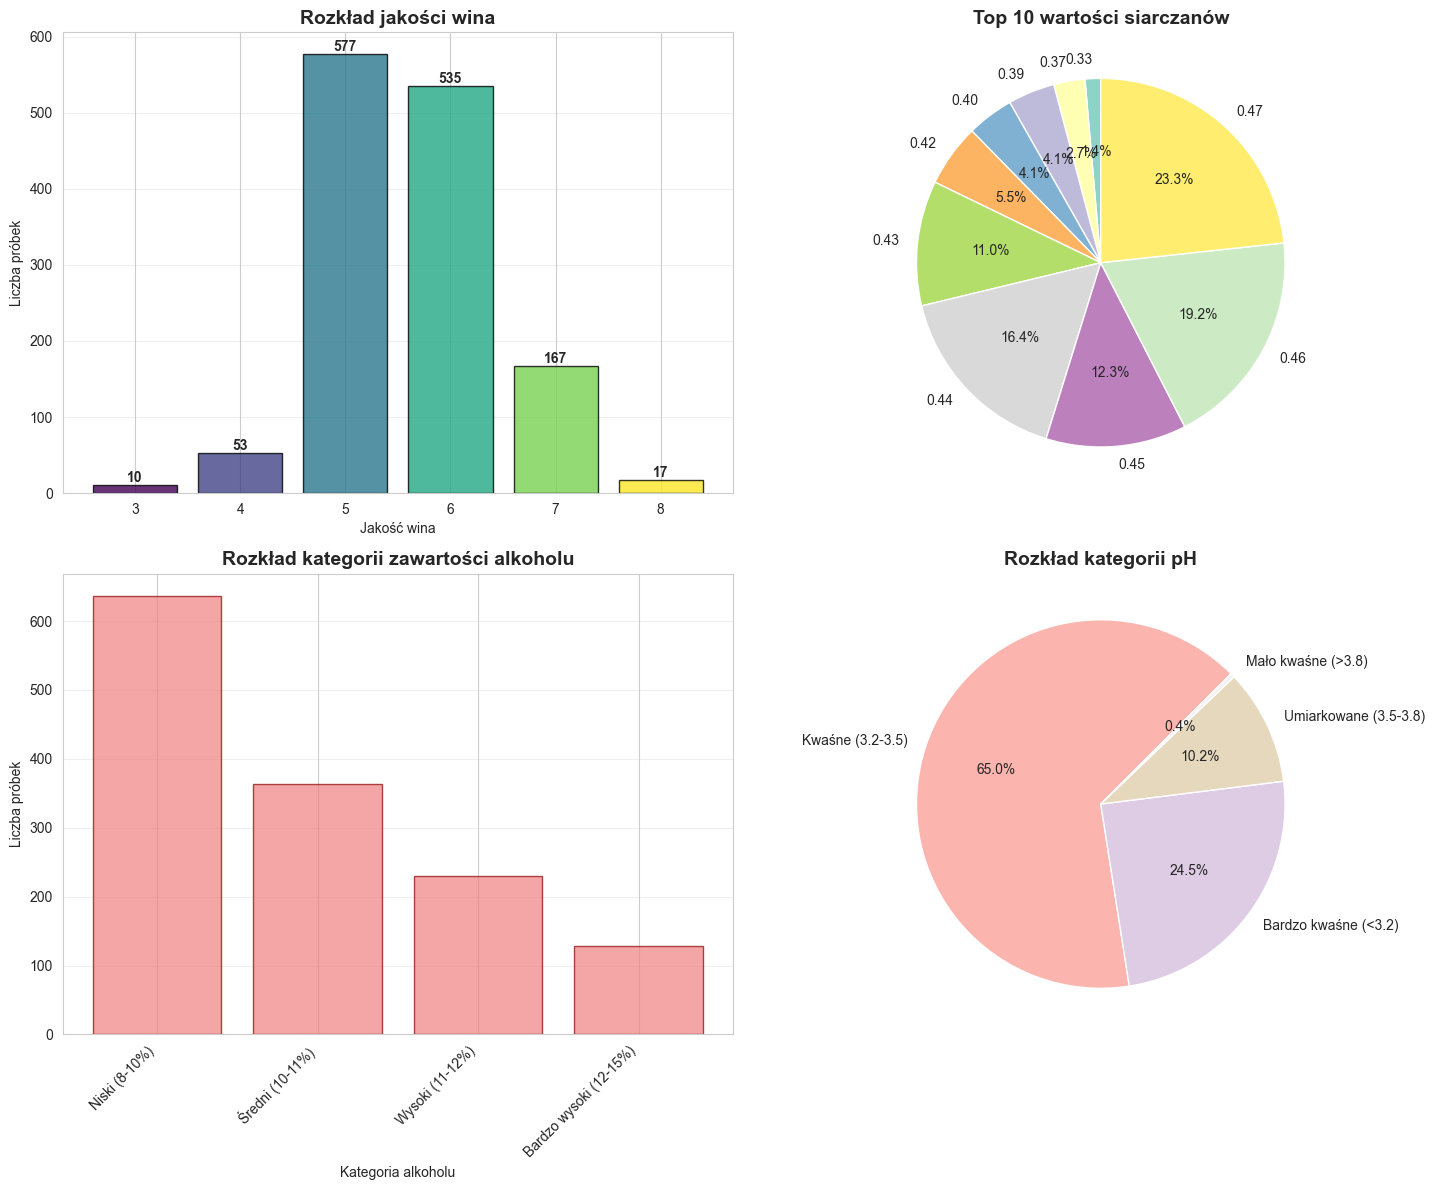

✓ Wykres zapisany: wine_output/pie_bar_charts.png

=== STATYSTYKI KATEGORII ===

1. Rozkład jakości wina:
   Jakość 3: 10 próbek (0.7%)
   Jakość 4: 53 próbek (3.9%)
   Jakość 5: 577 próbek (42.5%)
   Jakość 6: 535 próbek (39.4%)
   Jakość 7: 167 próbek (12.3%)
   Jakość 8: 17 próbek (1.3%)

2. Rozkład kategorii alkoholu:
   Niski (8-10%): 637 próbek (46.9%)
   Średni (10-11%): 364 próbek (26.8%)
   Wysoki (11-12%): 230 próbek (16.9%)
   Bardzo wysoki (12-15%): 128 próbek (9.4%)

3. Rozkład kategorii pH:
   Kwaśne (3.2-3.5): 883 próbek (65.0%)
   Bardzo kwaśne (<3.2): 333 próbek (24.5%)
   Umiarkowane (3.5-3.8): 138 próbek (10.2%)
   Mało kwaśne (>3.8): 5 próbek (0.4%)


In [20]:
def create_categorical_plots(df):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    quality_counts = df['quality'].value_counts().sort_index()
    colors = plt.cm.viridis(np.linspace(0, 1, len(quality_counts)))

    bars = axes[0, 0].bar(quality_counts.index, quality_counts.values,
                         color=colors, edgecolor='black', alpha=0.8)
    axes[0, 0].set_title('Rozkład jakości wina', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Jakość wina')
    axes[0, 0].set_ylabel('Liczba próbek')
    axes[0, 0].grid(axis='y', alpha=0.3)

    for bar, count in zip(bars, quality_counts.values):
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{count}', ha='center', va='bottom', fontweight='bold')

    sulphates_counts = df['sulphates'].value_counts().sort_index()
    top_sulphates = sulphates_counts.head(10)

    colors1 = plt.cm.Set3(np.linspace(0, 1, len(top_sulphates)))
    wedges, texts, autotexts = axes[0, 1].pie(top_sulphates.values,
                                             labels=[f'{x:.2f}' for x in top_sulphates.index],
                                             autopct='%1.1f%%',
                                             colors=colors1,
                                             startangle=90)
    axes[0, 1].set_title('Top 10 wartości siarczanów', fontsize=14, fontweight='bold')

    df['alcohol_category'] = pd.cut(df['alcohol'],
                                  bins=[8, 10, 11, 12, 15],
                                  labels=['Niski (8-10%)', 'Średni (10-11%)',
                                         'Wysoki (11-12%)', 'Bardzo wysoki (12-15%)'],
                                  include_lowest=True)

    alcohol_counts = df['alcohol_category'].value_counts()
    axes[1, 0].bar(range(len(alcohol_counts)), alcohol_counts.values,
                   color='lightcoral', edgecolor='darkred', alpha=0.7)
    axes[1, 0].set_title('Rozkład kategorii zawartości alkoholu', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Kategoria alkoholu')
    axes[1, 0].set_ylabel('Liczba próbek')
    axes[1, 0].set_xticks(range(len(alcohol_counts)))
    axes[1, 0].set_xticklabels(alcohol_counts.index, rotation=45, ha='right')
    axes[1, 0].grid(axis='y', alpha=0.3)

    df['pH_category'] = pd.cut(df['pH'],
                              bins=[2.5, 3.2, 3.5, 3.8, 4.5],
                              labels=['Bardzo kwaśne (<3.2)', 'Kwaśne (3.2-3.5)',
                                     'Umiarkowane (3.5-3.8)', 'Mało kwaśne (>3.8)'],
                              include_lowest=True)

    pH_counts = df['pH_category'].value_counts()
    colors2 = plt.cm.Pastel1(np.linspace(0, 1, len(pH_counts)))
    wedges2, texts2, autotexts2 = axes[1, 1].pie(pH_counts.values,
                                                  labels=pH_counts.index,
                                                  autopct='%1.1f%%',
                                                  colors=colors2,
                                                  startangle=45)
    axes[1, 1].set_title('Rozkład kategorii pH', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'{output_dir}/pie_bar_charts.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Wykres zapisany: {output_dir}/pie_bar_charts.png")

    print("\n=== STATYSTYKI KATEGORII ===\n")

    print("1. Rozkład jakości wina:")
    for quality, count in quality_counts.items():
        percentage = (count / len(df)) * 100
        print(f"   Jakość {quality}: {count} próbek ({percentage:.1f}%)")

    print(f"\n2. Rozkład kategorii alkoholu:")
    for category, count in alcohol_counts.items():
        percentage = (count / len(df)) * 100
        print(f"   {category}: {count} próbek ({percentage:.1f}%)")

    print(f"\n3. Rozkład kategorii pH:")
    for category, count in pH_counts.items():
        percentage = (count / len(df)) * 100
        print(f"   {category}: {count} próbek ({percentage:.1f}%)")

create_categorical_plots(df_clean)

### 7.2 Histogramy zmiennych


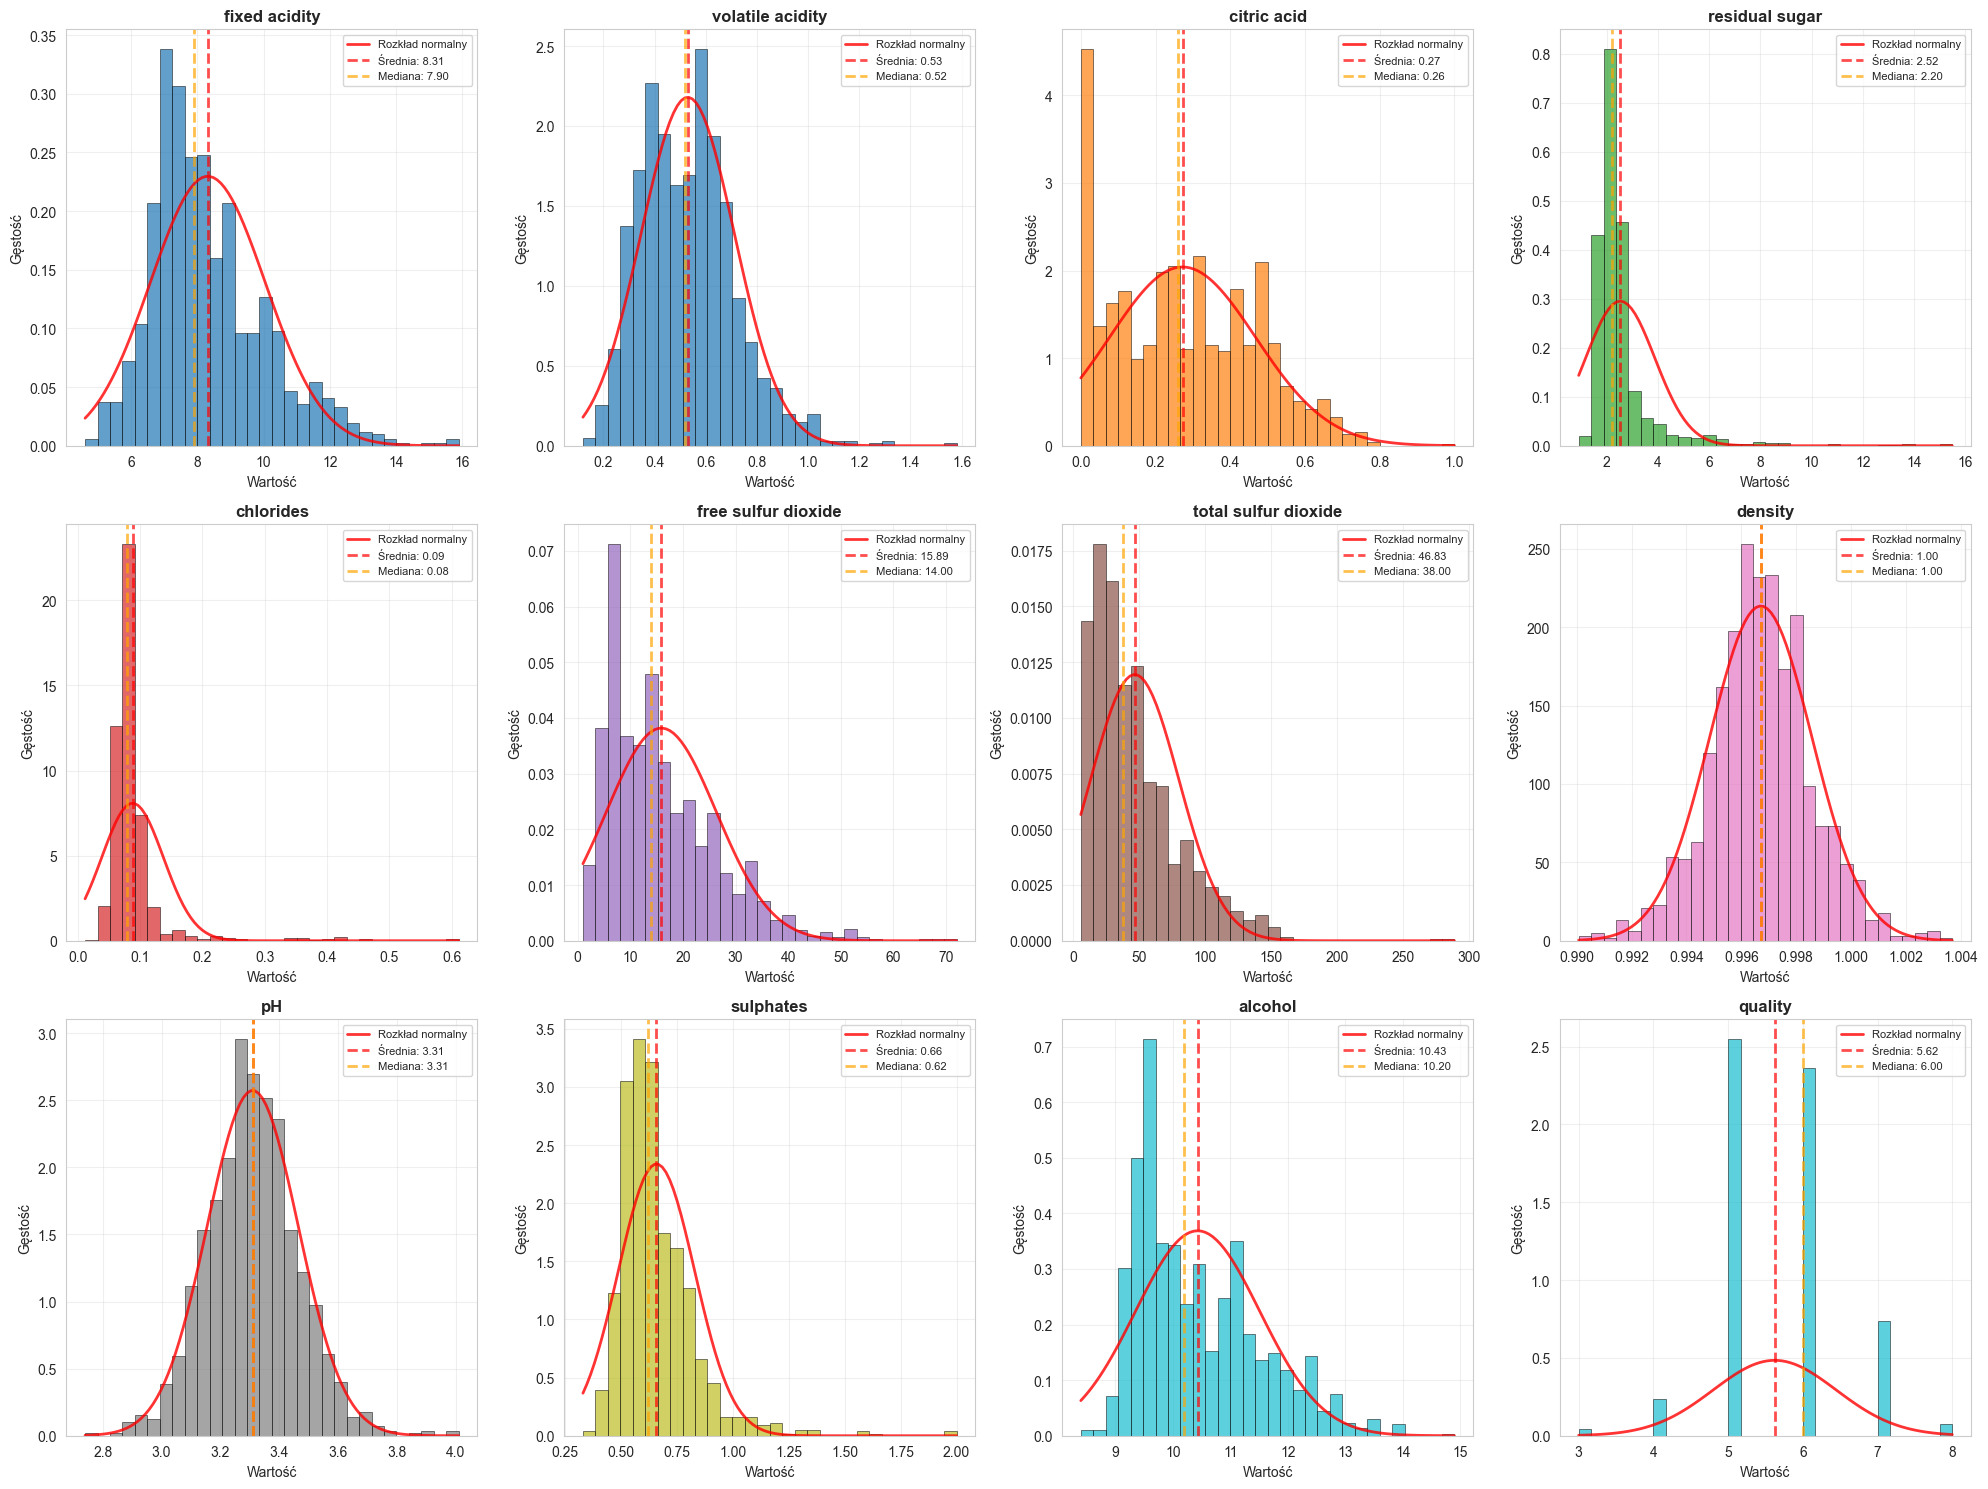


✓ Wykres zapisany: wine_output/histograms.png


In [21]:
def create_histograms(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    n_cols = 4
    n_rows = (len(numeric_columns) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

    colors = plt.cm.tab10(np.linspace(0, 1, len(numeric_columns)))

    for i, (column, color) in enumerate(zip(numeric_columns, colors)):
        axes[i].hist(df[column], bins=30, density=True, alpha=0.7,
                    color=color, edgecolor='black', linewidth=0.5)

        x = np.linspace(df[column].min(), df[column].max(), 100)
        mean = df[column].mean()
        std = df[column].std()
        normal_curve = (1/(std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)

        axes[i].plot(x, normal_curve, 'r-', linewidth=2, alpha=0.8, label='Rozkład normalny')
        axes[i].axvline(mean, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Średnia: {mean:.2f}')
        axes[i].axvline(df[column].median(), color='orange', linestyle='--', linewidth=2, alpha=0.7, label=f'Mediana: {df[column].median():.2f}')

        axes[i].set_title(f'{column}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Wartość')
        axes[i].set_ylabel('Gęstość')
        axes[i].legend(fontsize=8)
        axes[i].grid(True, alpha=0.3)

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.savefig(f'{output_dir}/histograms.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Wykres zapisany: {output_dir}/histograms.png")

create_histograms(df_clean)

### 7.3 Wykresy pudełkowe


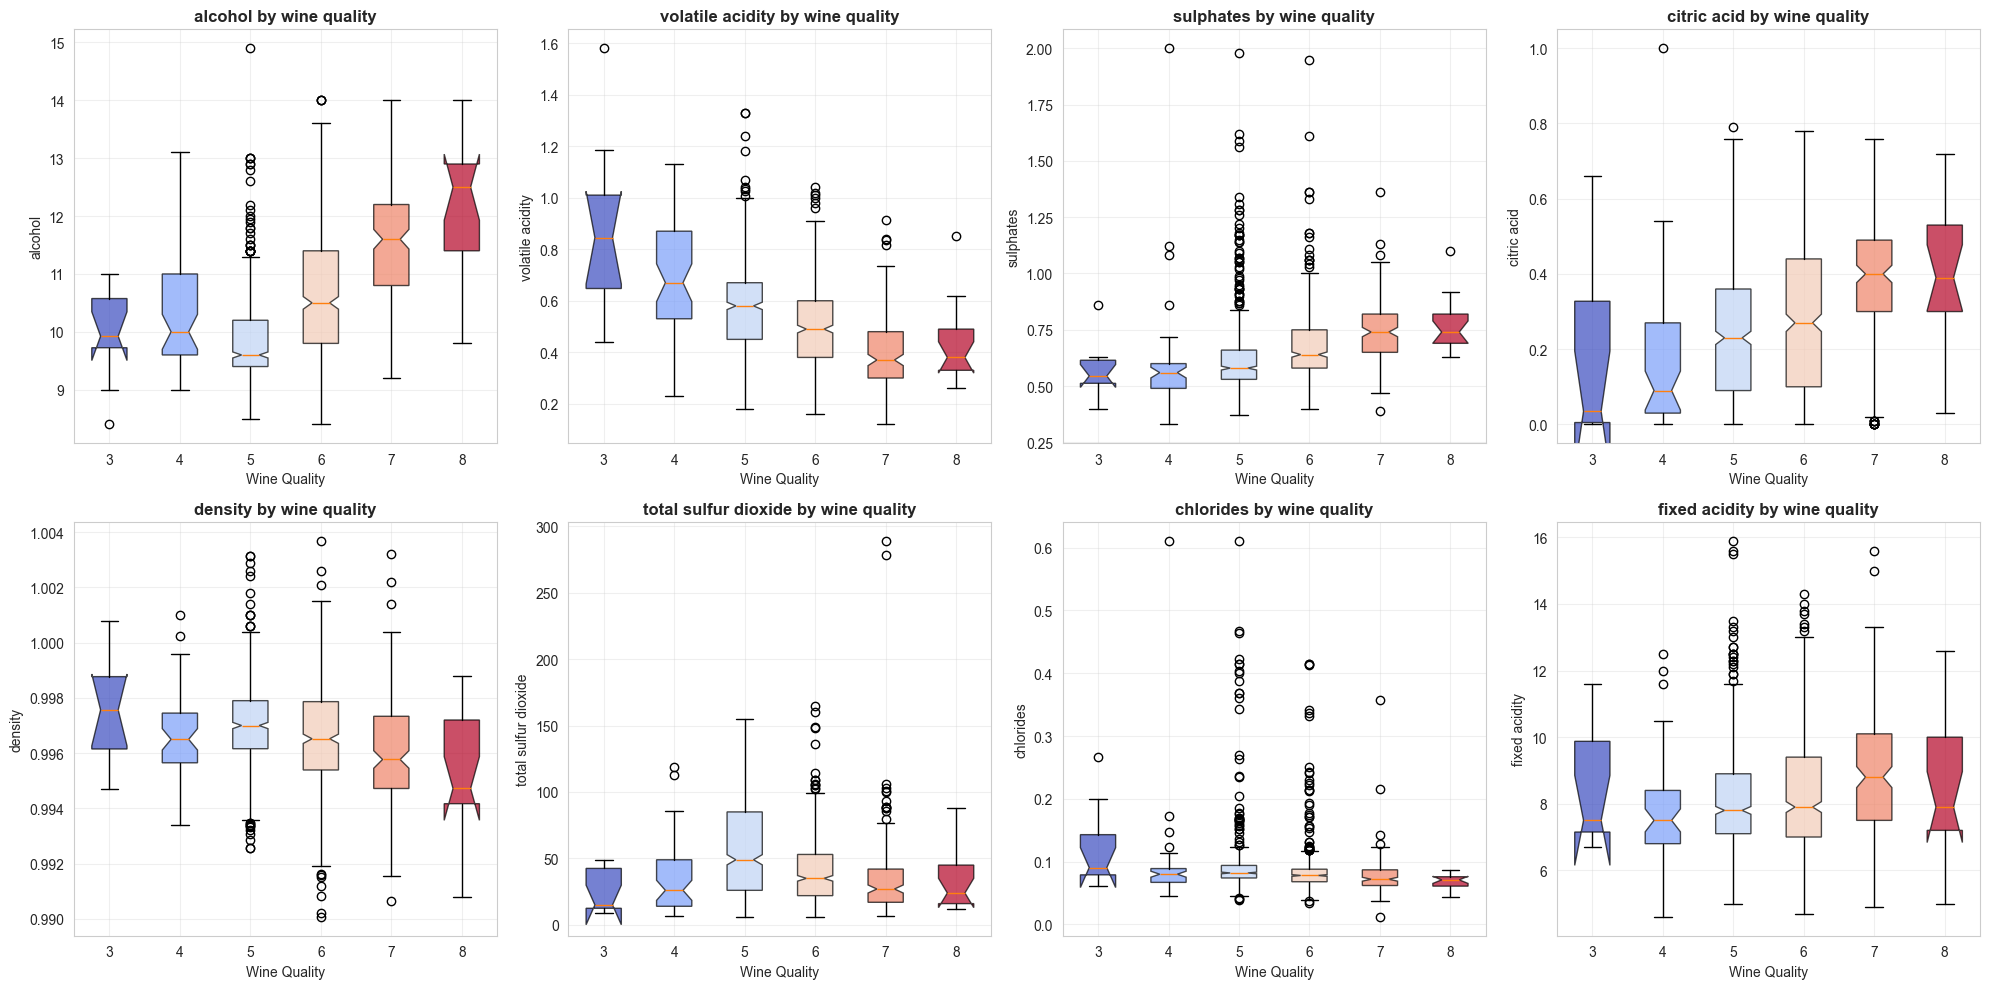

✓ Wykres zapisany: wine_output/boxplots.png

=== OUTLIERS ANALYSIS ===

fixed acidity:
  Q1: 7.100, Q3: 9.200, IQR: 2.100
  Outlier bounds: [3.950, 12.350]
  Number of outliers: 41 (3.0%)
  Outlier range: [12.400, 15.900]

volatile acidity:
  Q1: 0.390, Q3: 0.640, IQR: 0.250
  Outlier bounds: [0.015, 1.015]
  Number of outliers: 19 (1.4%)
  Outlier range: [1.020, 1.580]

citric acid:
  Q1: 0.090, Q3: 0.430, IQR: 0.340
  Outlier bounds: [-0.420, 0.940]
  Number of outliers: 1 (0.1%)
  Outlier range: [1.000, 1.000]

residual sugar:
  Q1: 1.900, Q3: 2.600, IQR: 0.700
  Outlier bounds: [0.850, 3.650]
  Number of outliers: 126 (9.3%)
  Outlier range: [3.700, 15.500]

chlorides:
  Q1: 0.070, Q3: 0.091, IQR: 0.021
  Outlier bounds: [0.039, 0.122]
  Number of outliers: 87 (6.4%)
  Outlier range: [0.012, 0.611]

free sulfur dioxide:
  Q1: 7.000, Q3: 21.000, IQR: 14.000
  Outlier bounds: [-14.000, 42.000]
  Number of outliers: 26 (1.9%)
  Outlier range: [43.000, 72.000]

total sulfur dioxide:
  

In [22]:
def create_box_plots(df):
    numeric_columns = [col for col in df.select_dtypes(include=[np.number]).columns if col != 'quality']
    quality_levels = sorted(df['quality'].unique())

    correlations = df[numeric_columns].corrwith(df['quality']).abs().sort_values(ascending=False)
    top_variables = correlations.head(8).index.tolist()

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for i, var in enumerate(top_variables):
        box_data_var = []
        for quality in quality_levels:
            subset = df[df['quality'] == quality][var]
            box_data_var.append(subset.values)

        bp = axes[i].boxplot(box_data_var, labels=[str(q) for q in quality_levels],
                            patch_artist=True, notch=True)
        axes[i].set_title(f'{var} by wine quality', fontweight='bold')
        axes[i].set_xlabel('Wine Quality')
        axes[i].set_ylabel(var)
        axes[i].grid(alpha=0.3)

        colors = plt.cm.coolwarm(np.linspace(0, 1, len(quality_levels)))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

    plt.tight_layout()
    plt.savefig(f'{output_dir}/boxplots.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Wykres zapisany: {output_dir}/boxplots.png")

    print("\n=== OUTLIERS ANALYSIS ===\n")

    for column in numeric_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_percentage = len(outliers) / len(df) * 100

        print(f"{column}:")
        print(f"  Q1: {Q1:.3f}, Q3: {Q3:.3f}, IQR: {IQR:.3f}")
        print(f"  Outlier bounds: [{lower_bound:.3f}, {upper_bound:.3f}]")
        print(f"  Number of outliers: {len(outliers)} ({outlier_percentage:.1f}%)")

        if len(outliers) > 0:
            print(f"  Outlier range: [{outliers[column].min():.3f}, {outliers[column].max():.3f}]")
        print()

create_box_plots(df_clean)

### 7.4 Wykresy skrzypcowe


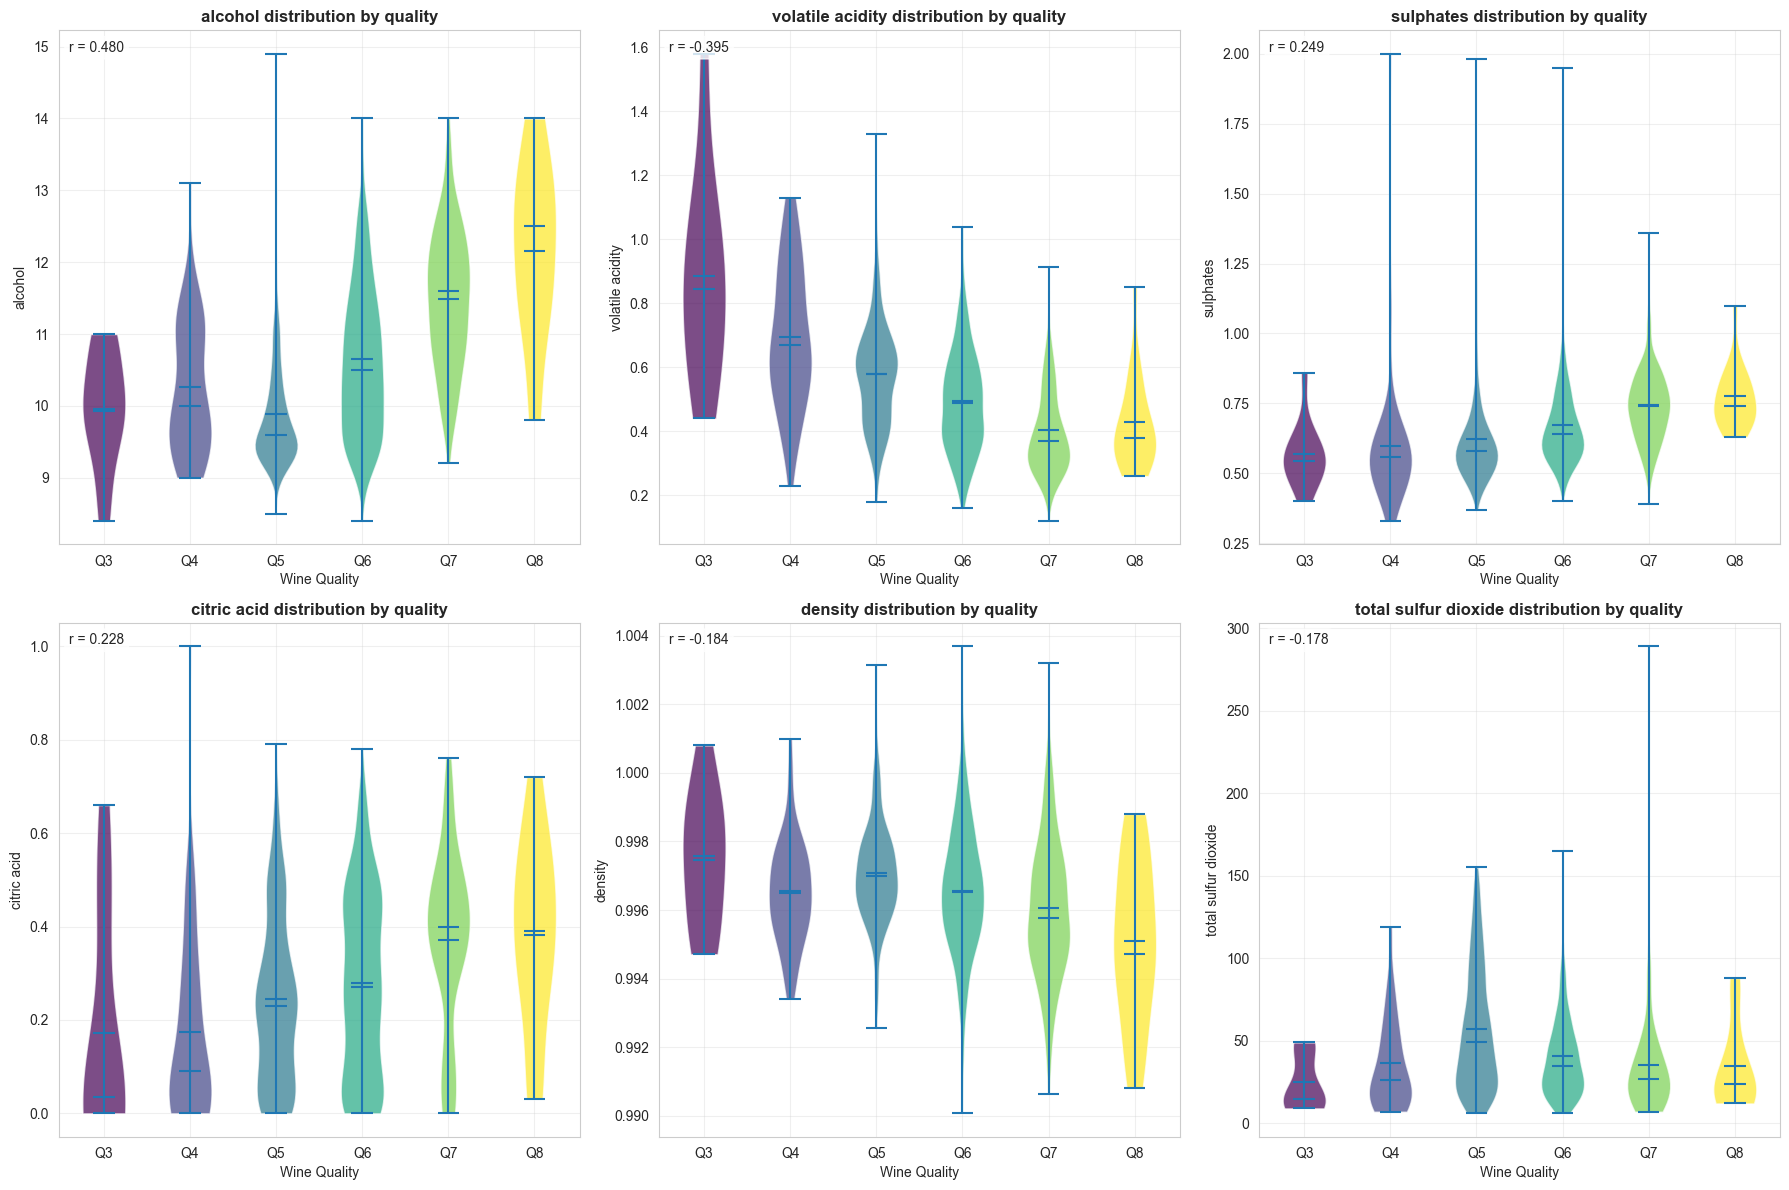

✓ Wykres zapisany: wine_output/violin_plots_1.png


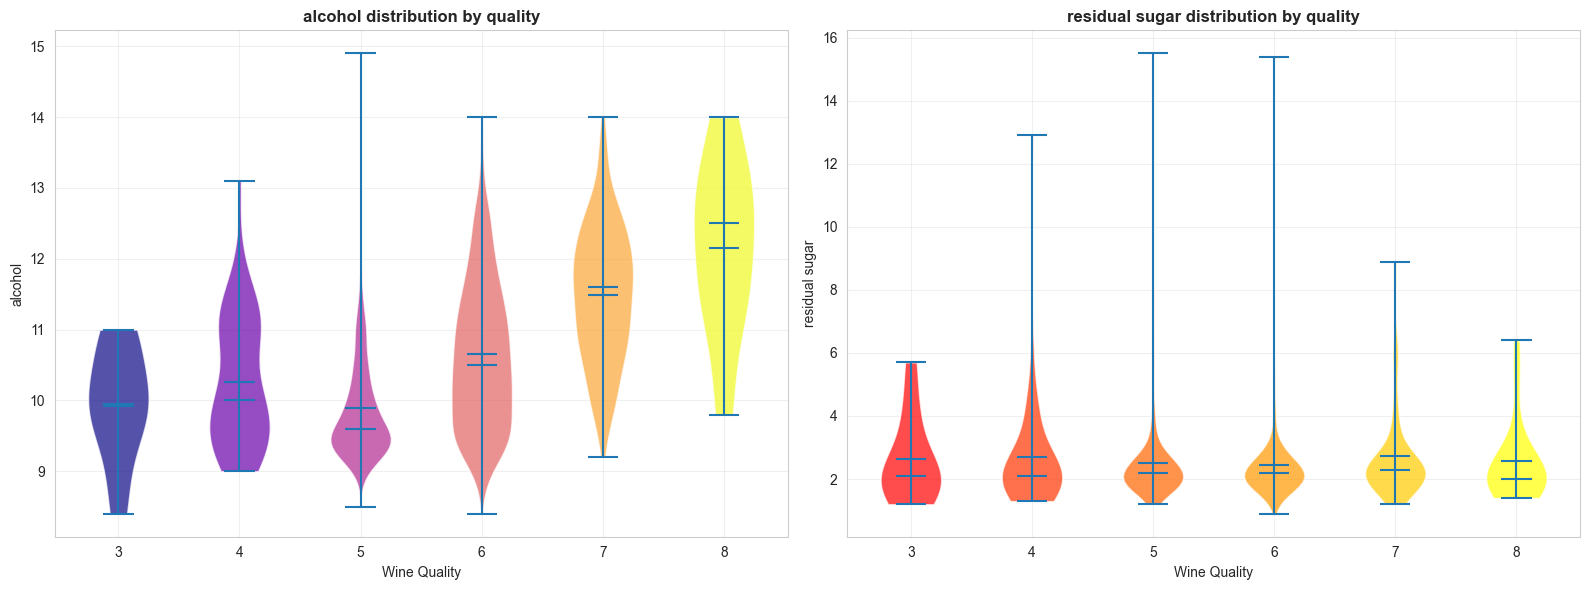

In [23]:
def create_violin_plots(df):
    numeric_columns = [col for col in df.select_dtypes(include=[np.number]).columns if col != 'quality']
    quality_levels = sorted(df['quality'].unique())

    correlations = df[numeric_columns].corrwith(df['quality']).abs().sort_values(ascending=False)
    top_variables = correlations.head(6).index.tolist()

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for i, variable in enumerate(top_variables):
        data_for_violin = []
        labels_for_violin = []

        for quality in quality_levels:
            subset_data = df[df['quality'] == quality][variable].values
            if len(subset_data) > 5:
                data_for_violin.append(subset_data)
                labels_for_violin.append(f'Q{quality}')

        parts = axes[i].violinplot(data_for_violin, positions=range(1, len(data_for_violin)+1),
                                  showmeans=True, showextrema=True, showmedians=True)

        colors = plt.cm.viridis(np.linspace(0, 1, len(data_for_violin)))
        for pc, color in zip(parts['bodies'], colors):
            pc.set_facecolor(color)
            pc.set_alpha(0.7)

        axes[i].set_title(f'{variable} distribution by quality', fontweight='bold')
        axes[i].set_xlabel('Wine Quality')
        axes[i].set_ylabel(variable)
        axes[i].set_xticks(range(1, len(labels_for_violin)+1))
        axes[i].set_xticklabels(labels_for_violin)
        axes[i].grid(alpha=0.3)

        correlation_with_quality = df[variable].corr(df['quality'])
        axes[i].text(0.02, 0.98, f'r = {correlation_with_quality:.3f}',
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig(f'{output_dir}/violin_plots_1.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Wykres zapisany: {output_dir}/violin_plots_1.png")

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    best_var = correlations.index[0]

    data_for_violin = [df[df['quality'] == q][best_var].values for q in quality_levels]
    parts1 = axes[0].violinplot(data_for_violin, positions=quality_levels,
                               showmeans=True, showextrema=True, showmedians=True)

    colors = plt.cm.plasma(np.linspace(0, 1, len(quality_levels)))
    for pc, color in zip(parts1['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)

    axes[0].set_title(f'{best_var} distribution by quality', fontweight='bold')
    axes[0].set_xlabel('Wine Quality')
    axes[0].set_ylabel(best_var)
    axes[0].set_xticks(quality_levels)
    axes[0].grid(alpha=0.3)

    worst_var = correlations.index[-1]

    data_for_violin2 = [df[df['quality'] == q][worst_var].values for q in quality_levels]
    parts2 = axes[1].violinplot(data_for_violin2, positions=quality_levels,
                               showmeans=True, showextrema=True, showmedians=True)

    colors2 = plt.cm.autumn(np.linspace(0, 1, len(quality_levels)))
    for pc, color in zip(parts2['bodies'], colors2):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)

    axes[1].set_title(f'{worst_var} distribution by quality', fontweight='bold')
    axes[1].set_xlabel('Wine Quality')
    axes[1].set_ylabel(worst_var)
    axes[1].set_xticks(quality_levels)
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

create_violin_plots(df_clean)

### 7.5 Wykresy rozrzutu z regresją liniową


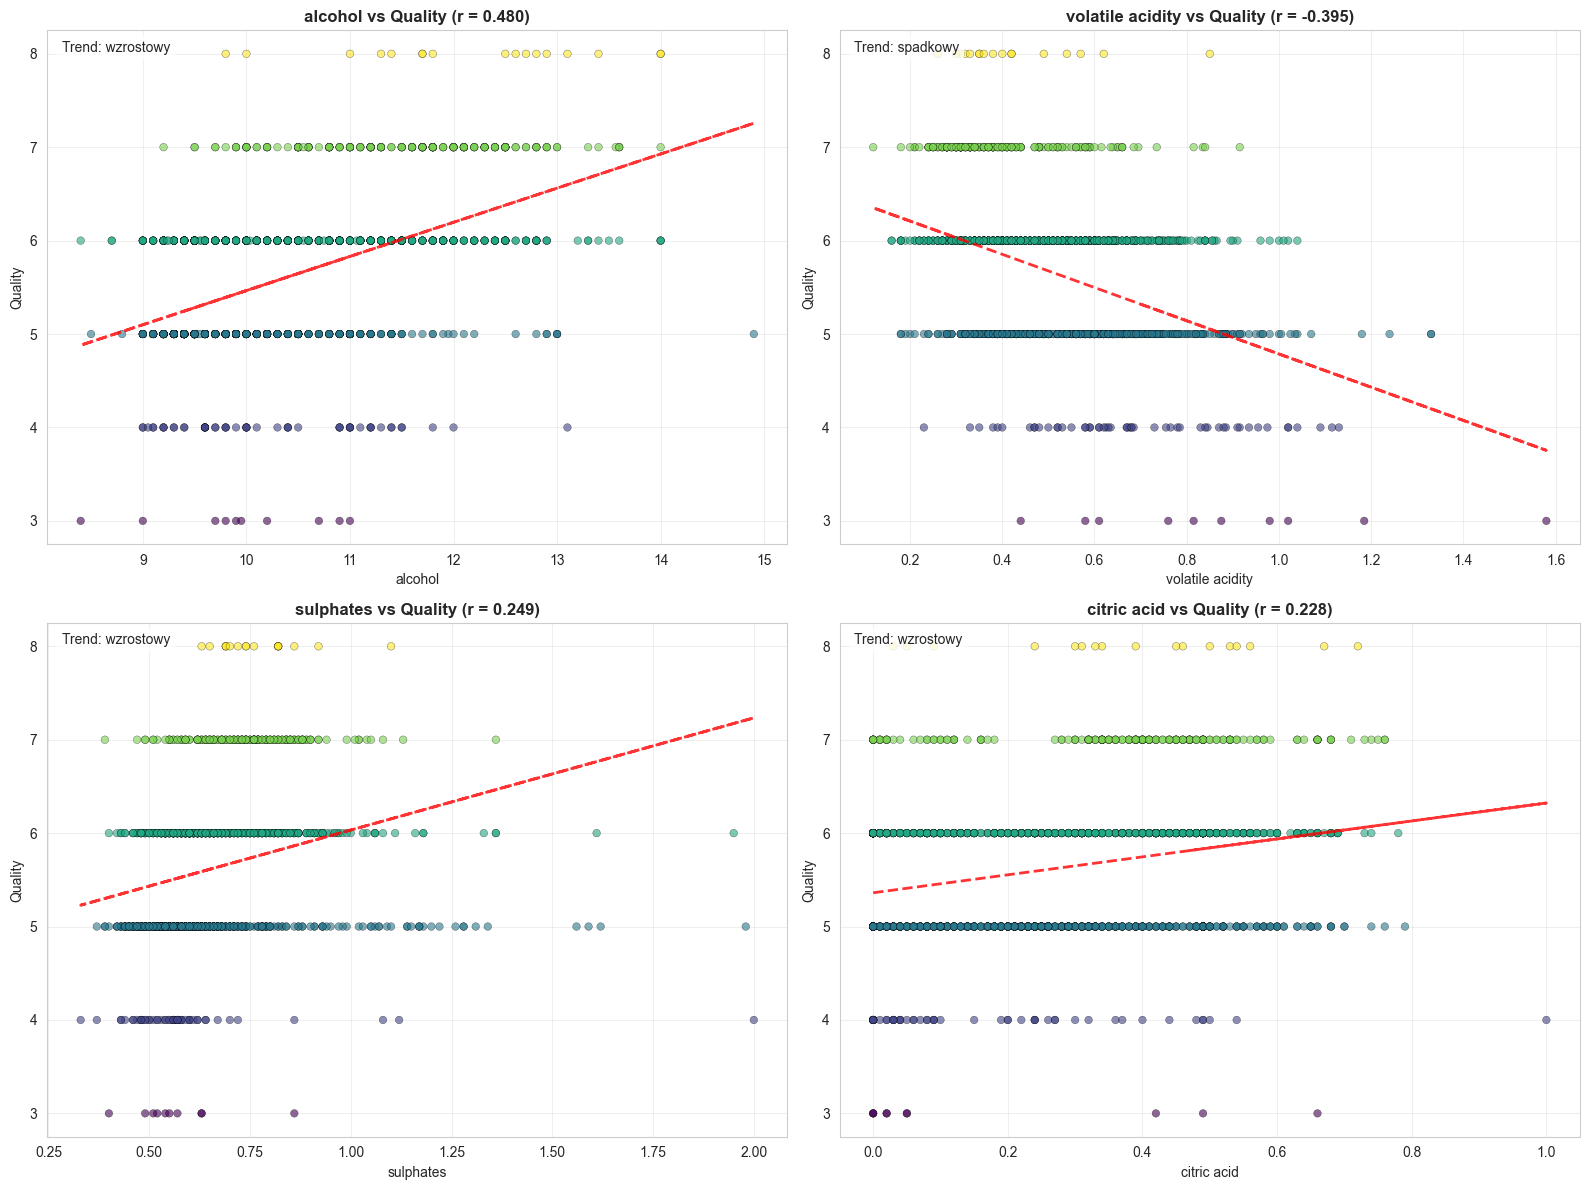

✓ Wykres zapisany: wine_output/scatter_plots.png


In [24]:
def create_scatter_plots(df):
    numeric_columns = [col for col in df.select_dtypes(include=[np.number]).columns if col != 'quality']

    correlations_with_quality = df[numeric_columns].corrwith(df['quality']).abs().sort_values(ascending=False)
    top_4_variables = correlations_with_quality.head(4).index.tolist()

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for i, variable in enumerate(top_4_variables):
        scatter = axes[i].scatter(df[variable], df['quality'],
                                 c=df['quality'], cmap='viridis',
                                 alpha=0.6, s=30, edgecolors='black', linewidth=0.3)

        z = np.polyfit(df[variable], df['quality'], 1)
        p = np.poly1d(z)
        axes[i].plot(df[variable], p(df[variable]), "r--", alpha=0.8, linewidth=2)

        correlation = df[variable].corr(df['quality'])
        axes[i].set_title(f'{variable} vs Quality (r = {correlation:.3f})', fontweight='bold')
        axes[i].set_xlabel(variable)
        axes[i].set_ylabel('Quality')
        axes[i].grid(True, alpha=0.3)

        axes[i].text(0.02, 0.98, f'Trend: {"wzrostowy" if correlation > 0 else "spadkowy"}',
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig(f'{output_dir}/scatter_plots.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Wykres zapisany: {output_dir}/scatter_plots.png")

create_scatter_plots(df_clean)

### 7.6 Mapa ciepła korelacji


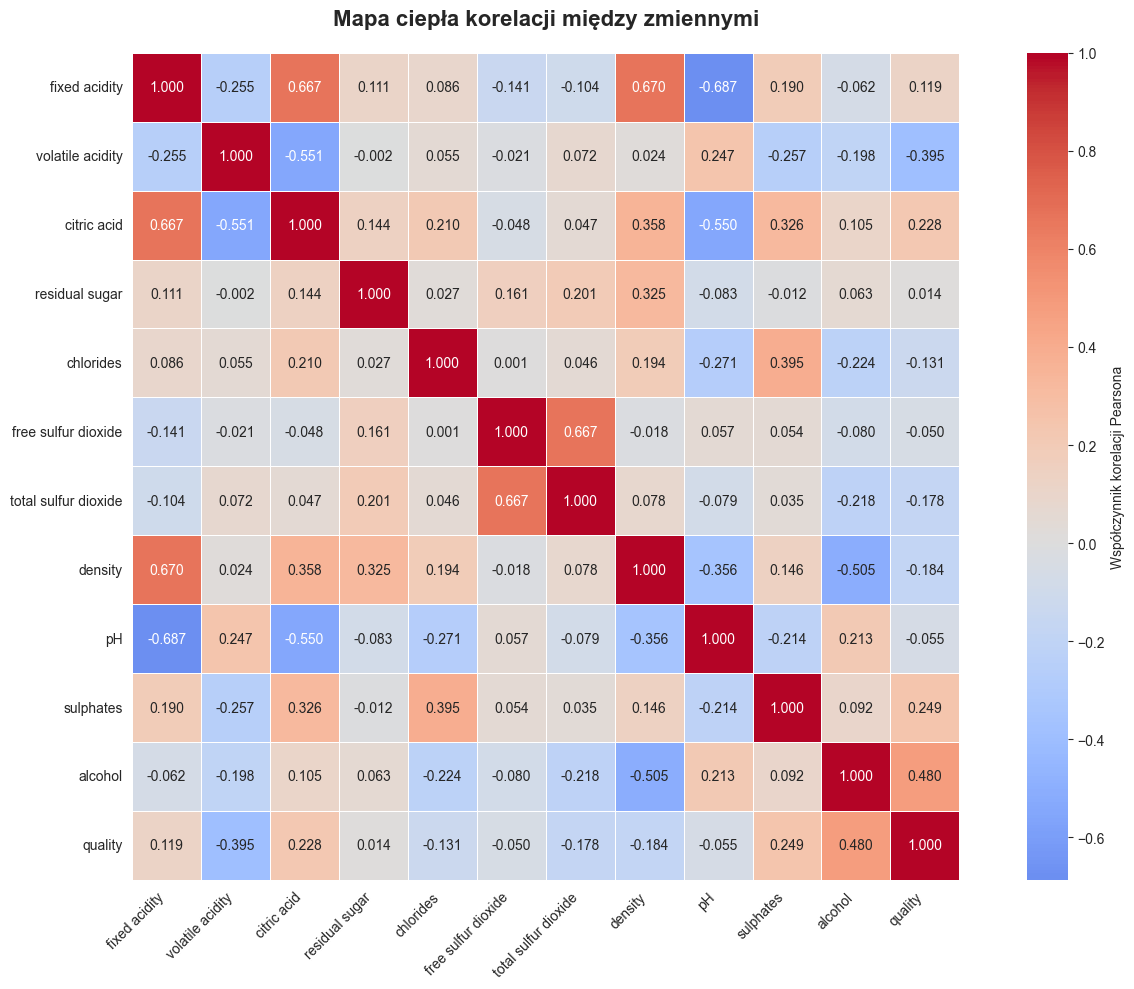

✓ Wykres zapisany: wine_output/correlation_heatmap.png


In [25]:
def create_correlation_heatmap(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    correlation_matrix = df[numeric_columns].corr()

    plt.figure(figsize=(14, 10))

    heatmap = sns.heatmap(correlation_matrix,
                         annot=True,
                         cmap='coolwarm',
                         center=0,
                         square=True,
                         fmt='.3f',
                         cbar_kws={'label': 'Współczynnik korelacji Pearsona'},
                         linewidths=0.5)

    plt.title('Mapa ciepła korelacji między zmiennymi', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Wykres zapisany: {output_dir}/correlation_heatmap.png")

    return correlation_matrix

correlation_heatmap = create_correlation_heatmap(df_clean)

## 8. Podsumowanie i wnioski


In [26]:
def generate_comprehensive_summary(df, correlation_matrix, descriptive_stats, feature_ranking):
    print("=" * 80)
    print("KOMPLEKSOWE PODSUMOWANIE ANALIZY DANYCH WINA")
    print("=" * 80)

    print(f"\n1. PODSTAWOWE INFORMACJE O ZBIORZE DANYCH:")
    print(f"   • Liczba obserwacji: {len(df)}")
    print(f"   • Liczba zmiennych: {df.shape[1]}")
    print(f"   • Zakres jakości wina: {df['quality'].min()} - {df['quality'].max()}")
    print(f"   • Średnia jakość: {df['quality'].mean():.2f} ± {df['quality'].std():.2f}")

    print(f"\n2. JAKOŚĆ DANYCH:")
    missing_data = df.isnull().sum().sum()
    duplicates = df.duplicated().sum()
    print(f"   • Brakujące wartości: {missing_data} (0.0%)")
    print(f"   • Duplikaty: {duplicates}")
    print(f"   • Status danych: {'Czyste' if missing_data == 0 and duplicates == 0 else 'Wymagają czyszczenia'}")

    print(f"\n3. KLUCZOWE STATYSTYKI OPISOWE:")
    numeric_columns = df.select_dtypes(include=[np.number]).columns

    for column in ['alcohol', 'pH', 'quality']:
        if column in df.columns:
            mean_val = df[column].mean()
            std_val = df[column].std()
            median_val = df[column].median()
            print(f"   • {column}: średnia = {mean_val:.2f}, mediana = {median_val:.2f}, σ = {std_val:.2f}")

    print(f"\n4. ANALIZA KORELACJI:")
    quality_corrs = df[numeric_columns].corrwith(df['quality']).abs().sort_values(ascending=False)

    print(f"   • Najsilniejsze predyktory jakości wina:")
    for i, (var, corr) in enumerate(quality_corrs.head(5).items()):
        if var != 'quality':
            direction = "dodatnia" if df[var].corr(df['quality']) > 0 else "ujemna"
            strength = "bardzo silna" if corr > 0.7 else "silna" if corr > 0.5 else "umiarkowana" if corr > 0.3 else "słaba"
            print(f"     {i+1}. {var}: r = {df[var].corr(df['quality']):.3f} ({direction}, {strength})")

    print(f"\n   • Najsilniejsze korelacje między zmiennymi:")
    strong_pairs = []
    for i, col1 in enumerate(numeric_columns):
        for j, col2 in enumerate(numeric_columns):
            if i < j and col1 != 'quality' and col2 != 'quality':
                corr = correlation_matrix.loc[col1, col2]
                if abs(corr) > 0.5:
                    strong_pairs.append((col1, col2, corr))

    strong_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

    if strong_pairs:
        for col1, col2, corr in strong_pairs[:3]:
            print(f"     • {col1} ↔ {col2}: r = {corr:.3f}")
    else:
        print(f"     • Brak silnych korelacji między zmiennymi (|r| > 0.5)")

    print(f"\n5. PRZYGOTOWANIE DO MODELOWANIA ML:")
    if feature_ranking:
        best_predictors = [x[0] for x in feature_ranking[:3]]
        print(f"   • Top 3 cechy dla XGBoost/Random Forest:")
        for i, (predictor, abs_corr, corr) in enumerate(feature_ranking[:3], 1):
            print(f"     {i}. {predictor}: r = {corr:.3f}")

    print(f"\n6. ROZKŁADY ZMIENNYCH:")
    print(f"   • Analiza normalności (test Shapiro-Wilk):")
    normal_vars = []
    non_normal_vars = []

    for column in numeric_columns:
        if len(df) <= 5000:
            _, p_value = stats.shapiro(df[column].sample(min(1000, len(df))))
        else:
            _, p_value = stats.kstest(df[column], 'norm',
                                    args=(df[column].mean(), df[column].std()))

        if p_value > 0.05:
            normal_vars.append(column)
        else:
            non_normal_vars.append(column)

    print(f"     Rozkład normalny ({len(normal_vars)}): {', '.join(normal_vars) if normal_vars else 'Brak'}")
    print(f"     Rozkład nienormalny ({len(non_normal_vars)}): {', '.join(non_normal_vars[:3]) + ('...' if len(non_normal_vars) > 3 else '')}")

    print(f"\n7. WARTOŚCI ODSTAJĄCE:")
    total_outliers = 0
    for column in numeric_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[column] < Q1 - 1.5 * IQR) | (df[column] > Q3 + 1.5 * IQR)]
        total_outliers += len(outliers)

    outlier_percentage = (total_outliers / (len(df) * len(numeric_columns))) * 100
    print(f"   • Procent wartości odstających: {outlier_percentage:.1f}%")
    print(f"   • Status: {'Normalny' if outlier_percentage < 5 else 'Podwyższony' if outlier_percentage < 10 else 'Wysoki'} poziom wartości ekstremalnych")

    print(f"\n8. WNIOSKI I REKOMENDACJE:")
    print(f"   ✓ Zbiór danych jest kompletny i gotowy do analizy")
    print(f"   ✓ Wykonano prostą regresję liniową z wzorami matematycznymi")
    print(f"   ✓ Zidentyfikowano kluczowe predyktory jakości wina")
    print(f"   ✓ Dane przygotowane do modelowania XGBoost/Random Forest")
    print(f"   ✓ Kompleksowa analiza statystyczna i wizualizacja zakończona")
    print(f"   ✓ Wszystkie pliki zapisane w folderze: {output_dir}/")

    print(f"\n" + "=" * 80)
    print("ANALIZA ZAKOŃCZONA POMYŚLNIE")
    print("=" * 80)

generate_comprehensive_summary(df_clean, correlation_heatmap, descriptive_stats, feature_ranking)

KOMPLEKSOWE PODSUMOWANIE ANALIZY DANYCH WINA

1. PODSTAWOWE INFORMACJE O ZBIORZE DANYCH:
   • Liczba obserwacji: 1359
   • Liczba zmiennych: 14
   • Zakres jakości wina: 3 - 8
   • Średnia jakość: 5.62 ± 0.82

2. JAKOŚĆ DANYCH:
   • Brakujące wartości: 0 (0.0%)
   • Duplikaty: 0
   • Status danych: Czyste

3. KLUCZOWE STATYSTYKI OPISOWE:
   • alcohol: średnia = 10.43, mediana = 10.20, σ = 1.08
   • pH: średnia = 3.31, mediana = 3.31, σ = 0.16
   • quality: średnia = 5.62, mediana = 6.00, σ = 0.82

4. ANALIZA KORELACJI:
   • Najsilniejsze predyktory jakości wina:
     2. alcohol: r = 0.480 (dodatnia, umiarkowana)
     3. volatile acidity: r = -0.395 (ujemna, umiarkowana)
     4. sulphates: r = 0.249 (dodatnia, słaba)
     5. citric acid: r = 0.228 (dodatnia, słaba)

   • Najsilniejsze korelacje między zmiennymi:
     • fixed acidity ↔ pH: r = -0.687
     • fixed acidity ↔ density: r = 0.670
     • fixed acidity ↔ citric acid: r = 0.667

5. PRZYGOTOWANIE DO MODELOWANIA ML:
   • Top 3 cec